## Importing packages

In [112]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import plotly.express as px

from scipy.special import inv_boxcox

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder


import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from patsy import dmatrices
import statsmodels.api as sm


## Loading data

and standardizing column headers before we move on...

In [113]:
df = pd.read_csv("data/creditcardmarketing.csv")

In [114]:
def clean_headers(df):
    cols = []
    for c in df.columns:
        c = c.lower().replace(" ", "_").replace("#", "n")
        cols.append(c)
    df.columns = cols


In [115]:
clean_headers(df)

## Exploring data

In [116]:
df.shape

(18000, 17)

In [117]:
pd.set_option('display.max_columns', None)
df.head(3)

,customer_number,offer_accepted,reward,mailer_type,income_level,n_bank_accounts_open,overdraft_protection,credit_rating,n_credit_cards_held,n_homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0


### Exploring Categoricals

In [118]:
df_cat = df.select_dtypes('object')
df_cat.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
0,No,Air Miles,Letter,High,No,High,No
1,No,Air Miles,Letter,Medium,No,Medium,Yes
2,No,Air Miles,Postcard,High,No,Medium,Yes
3,No,Air Miles,Letter,Medium,No,High,No
4,No,Air Miles,Letter,Medium,No,Medium,Yes


#### Lets see the number of distinct values each column has and what % of the total values belong to each type.

In [216]:
def cat_exploration(df):
    cat = df.select_dtypes('object')
    for c in cat.columns:
        print(c)
        print(cat[c].value_counts(normalize=True).mul(100).round(1))
        fig, axes = plt.subplots(1, 1, figsize=(7, 4))
        sns.set_style("darkgrid")
        sns.countplot(cat[c], color = 'gray')
        plt.show()

offer_accepted
No     94.3
Yes     5.7
Name: offer_accepted, dtype: float64


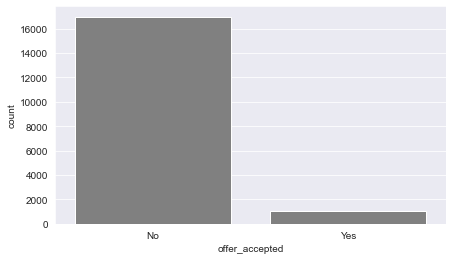

reward
Air Miles    33.7
Cash Back    33.3
Points       33.0
Name: reward, dtype: float64


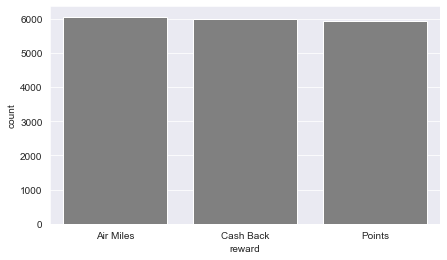

mailer_type
Postcard    50.8
Letter      49.2
Name: mailer_type, dtype: float64


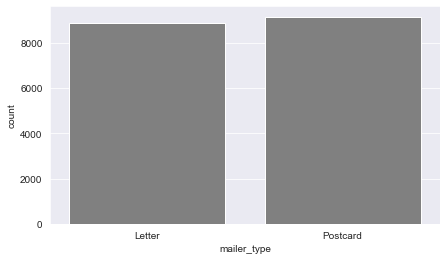

income_level
Medium    50.1
High      25.1
Low       24.8
Name: income_level, dtype: float64


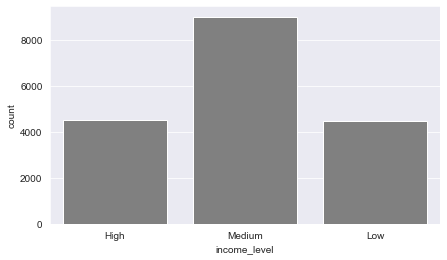

overdraft_protection
No     85.1
Yes    14.9
Name: overdraft_protection, dtype: float64


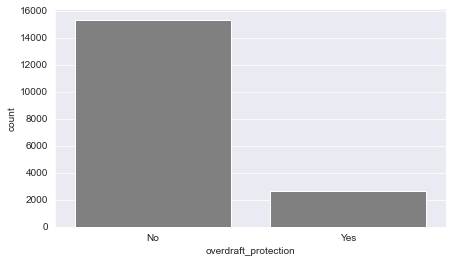

credit_rating
High      33.7
Medium    33.2
Low       33.1
Name: credit_rating, dtype: float64


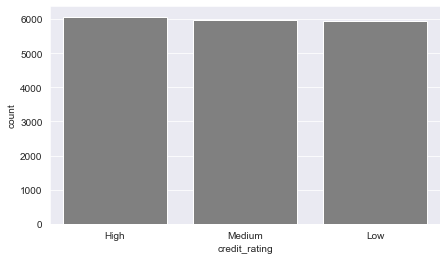

own_your_home
Yes    64.8
No     35.2
Name: own_your_home, dtype: float64


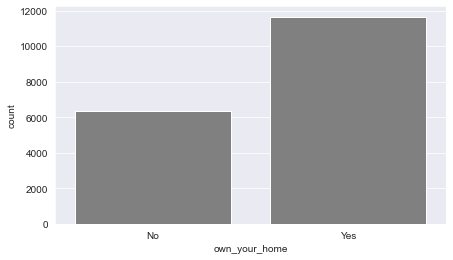

In [217]:
cat_exploration(df)

Takeaways:
- There isn't any categorical column with too many different value types which might require bucketing.
- The largest imbalance occurs with our target variable: "offer_accepted"

### Exploring numericals

In [218]:
def num_exploration(df):
    num = df.select_dtypes('number')
    for c in num.columns:
        print(c)
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        sns.set_style("darkgrid")
        sns.distplot(num[c], ax=axes[0],  color = 'gray')
        sns.boxplot(num[c], ax=axes[1],  color = 'gray')
        plt.show()
    return num.describe().apply(lambda x: round(x,2))

n_bank_accounts_open


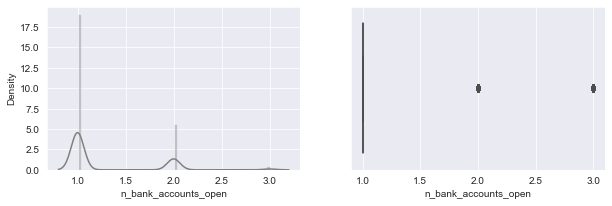

n_credit_cards_held


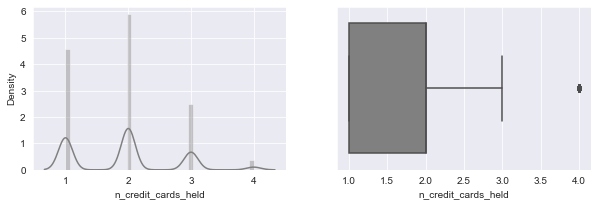

n_homes_owned


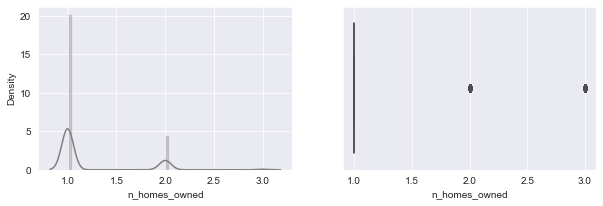

household_size


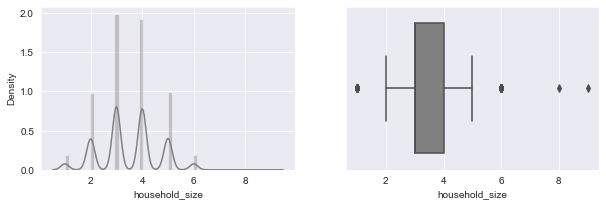

average_balance


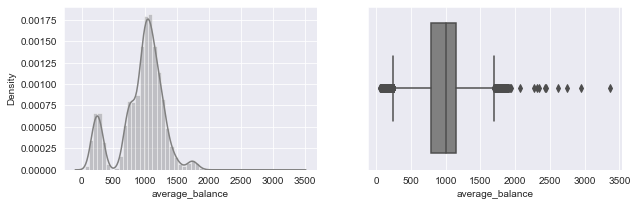

q1_balance


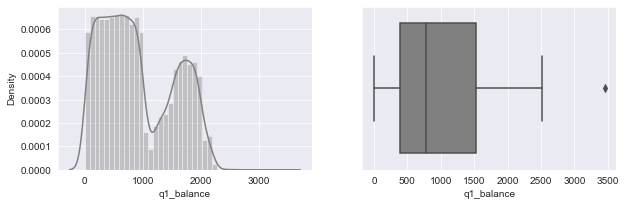

q2_balance


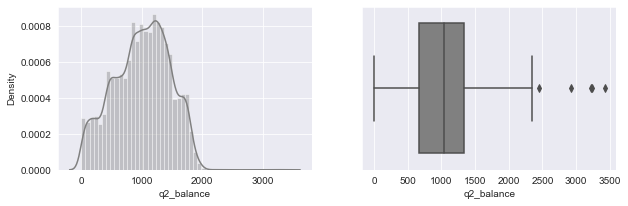

q3_balance


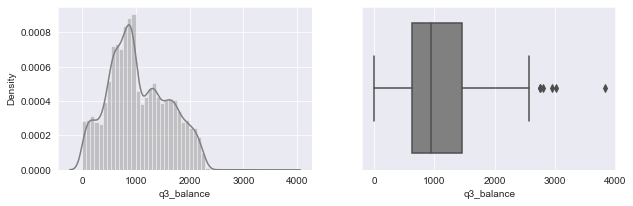

q4_balance


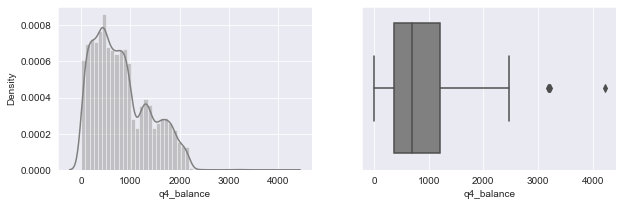

,n_bank_accounts_open,n_credit_cards_held,n_homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,18000.00,18000.0,18000.00,18000.00,18000.00,18000.00,18000.00,18000.00,18000.00
mean,1.26,1.9,1.20,3.50,940.52,910.45,999.39,1042.03,810.19
std,0.47,0.8,0.43,1.11,350.06,619.66,457.10,553.08,558.63
min,1.00,1.0,1.00,1.00,48.25,0.00,0.00,0.00,0.00
25%,1.00,1.0,1.00,3.00,787.94,393.00,664.00,633.00,363.75
50%,1.00,2.0,1.00,3.00,1006.50,773.00,1032.00,946.00,704.00
75%,1.00,2.0,1.00,4.00,1152.56,1520.25,1342.00,1462.00,1211.00
max,3.00,4.0,3.00,9.00,3366.25,3450.00,3421.00,3823.00,4215.00


In [219]:
num_exploration(df)

## Check correlations:

We are checking the correlation of the data by also creating modifications of the original one by dropping certain columns that have a lot of correlation. We will later see how do they dirrerently affect the model.

We create the different dfs

In [220]:
df1 = df.drop('average_balance', axis=1)
df2 = df.drop(['q1_balance','q2_balance','q3_balance','q4_balance'], axis=1)


We define the three correlation matrixes

In [221]:
corr_matrix=df.corr(method='pearson')
corr_matrix1=df1.corr(method='pearson')
corr_matrix2=df2.corr(method='pearson')

We plot them:

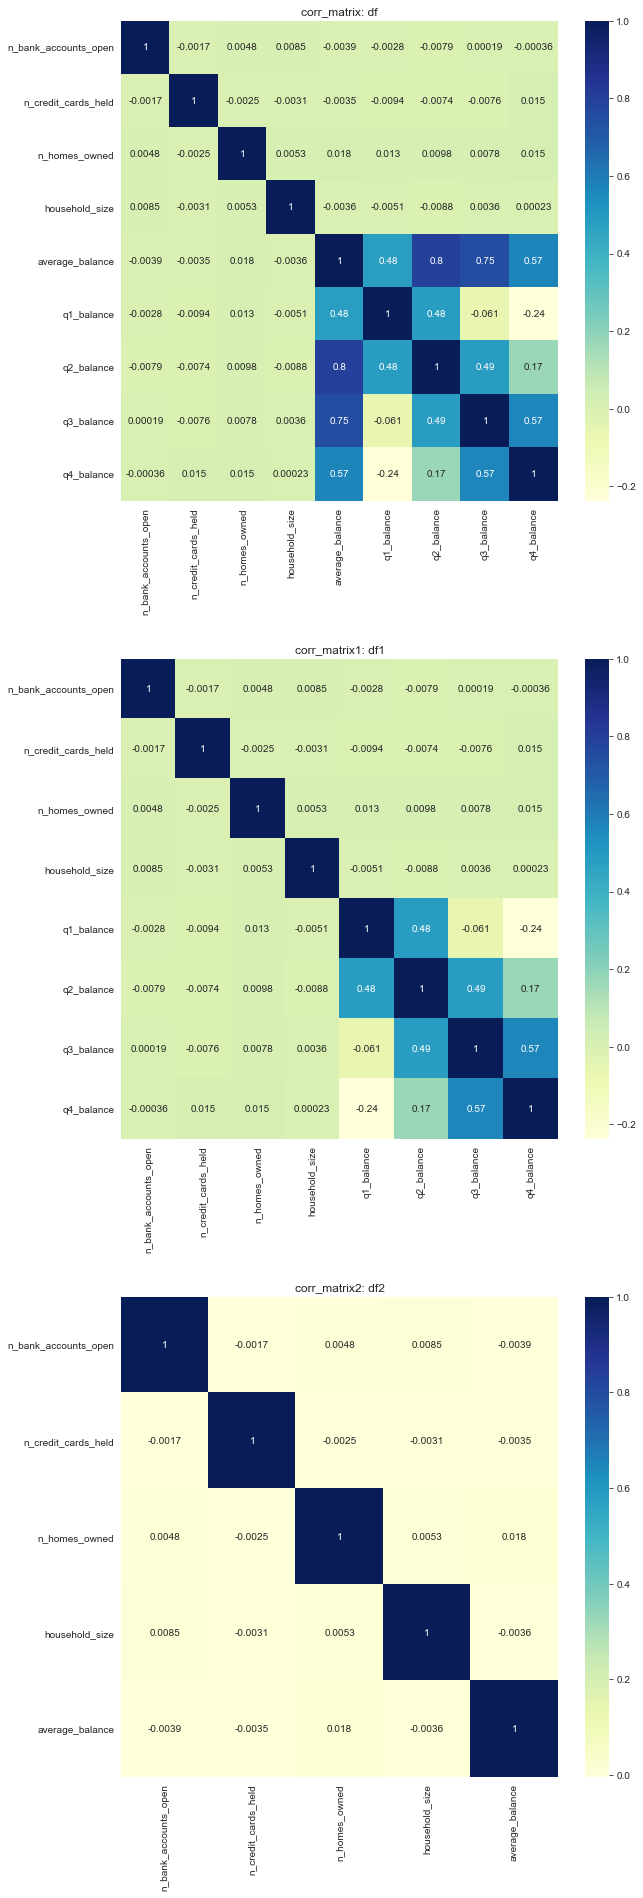

In [222]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10, 27))

sns.heatmap(corr_matrix, ax=ax1, annot=True, cmap="YlGnBu")
sns.heatmap(corr_matrix1, ax=ax2, annot=True, cmap="YlGnBu")
sns.heatmap(corr_matrix2, ax=ax3, annot=True, cmap="YlGnBu")

ax1.set_title('corr_matrix: df')
ax2.set_title('corr_matrix1: df1')
ax3.set_title('corr_matrix2: df2')
fig.tight_layout(pad=3.0)


plt.show()

### Checking null values:

In [223]:
def checking_nulls(df):
    for c in df.columns:
        null_count = df[c].isnull().sum()
        if null_count > 0:
            print ("The column ", c, " has ", null_count, " null values")
    nulls = df[df.isna().any(axis=1)]
    return nulls.head()

In [224]:
checking_nulls(df)

,offer_accepted,reward,mailer_type,income_level,n_bank_accounts_open,overdraft_protection,credit_rating,n_credit_cards_held,n_homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,


We will deal with null values later.

## Cleaning data

### Dealing with irrelevant columns

customer_number is important for the predictions, but i won't use it as a feature (unique values)


In [225]:
df = df.set_index('customer_number')

KeyError: "None of ['customer_number'] are in the columns"

### Dealing with null values

- We will replace null values with the mean as the data distribution for columns with null values is "slightly" normal (see previous graphs)

In [ ]:
def replace_nulls_mean(df):
    for c in df.columns:
        null_count = df[c].isnull().sum()
        if null_count > 0:
            df[c].fillna((df[c].mean()), inplace=True)
    return df

In [ ]:
df = replace_nulls_mean(df)
checking_nulls(df)

,offer_accepted,reward,mailer_type,income_level,n_bank_accounts_open,overdraft_protection,credit_rating,n_credit_cards_held,n_homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,


## Multicollinearity analysis

In [ ]:
df.columns


Index(['offer_accepted', 'reward', 'mailer_type', 'income_level',
       'n_bank_accounts_open', 'overdraft_protection', 'credit_rating',
       'n_credit_cards_held', 'n_homes_owned', 'household_size',
       'own_your_home', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance'],
      dtype='object')

In [ ]:
features = "+".join(['reward', 'mailer_type', 'income_level',
       'n_bank_accounts_open', 'overdraft_protection', 'credit_rating',
       'n_credit_cards_held', 'n_homes_owned', 'household_size',
       'own_your_home', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance'])

y, X = dmatrices('offer_accepted ~' + features, df, return_type='dataframe')

X

,Intercept,reward[T.Cash Back],reward[T.Points],mailer_type[T.Postcard],income_level[T.Low],income_level[T.Medium],overdraft_protection[T.Yes],credit_rating[T.Low],credit_rating[T.Medium],own_your_home[T.Yes],n_bank_accounts_open,n_credit_cards_held,n_homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,4.0,1160.75,1669.0,877.0,1095.0,1002.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,5.0,147.25,39.0,106.0,78.0,366.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,1.0,2.0,276.50,367.0,352.0,145.0,242.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,4.0,1219.00,1578.0,1760.0,1119.0,419.0
5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,6.0,1211.00,2140.0,1357.0,982.0,365.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17996,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,5.0,167.50,136.0,65.0,71.0,398.0
17997,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,3.0,1.0,3.0,850.50,984.0,940.0,943.0,535.0
17998,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,4.0,1087.25,918.0,767.0,1170.0,1494.0


In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif.round(1)

,VIF Factor,features
0,48.5,Intercept
1,1.3,reward[T.Cash Back]
2,1.3,reward[T.Points]
3,1.0,mailer_type[T.Postcard]
4,1.5,income_level[T.Low]
5,1.5,income_level[T.Medium]
6,1.0,overdraft_protection[T.Yes]
7,1.3,credit_rating[T.Low]
8,1.3,credit_rating[T.Medium]
9,1.0,own_your_home[T.Yes]


In [ ]:
data_corr = df.copy().dropna()
vif = {}
data_corr = add_constant(data_corr)
data_corr.shape


(18000, 17)

In [ ]:
'''
for i in np.arange(data_corr.shape[1]):
     column_name = data_corr.columns[i]
     print(i, column_name)
     value = variance_inflation_factor(np.array(data_corr), i)
     vif[column_name] = value

Code to use the variance_inflation_factor technique to remove highly correlated columns

flag = True
threshold = 50
data_corr = add_constant(data_corr)
while flag is True:
    #print(data_corr.head())
    flag = False
    values = [variance_inflation_factor(np.array(data_corr), i) for i in np.arange(data_corr.shape[1])]
    #print(values)
    if max(values)> threshold:
         col_index = values.index(max(values))
         column_name = data_corr.columns[col_index]
         data_corr = data_corr.drop([column_name], axis=1)
         flag = True
'''

'\nfor i in np.arange(data_corr.shape[1]):\n     column_name = data_corr.columns[i]\n     print(i, column_name)\n     value = variance_inflation_factor(np.array(data_corr), i)\n     vif[column_name] = value\n\nCode to use the variance_inflation_factor technique to remove highly correlated columns\n\nflag = True\nthreshold = 50\ndata_corr = add_constant(data_corr)\nwhile flag is True:\n    #print(data_corr.head())\n    flag = False\n    values = [variance_inflation_factor(np.array(data_corr), i) for i in np.arange(data_corr.shape[1])]\n    #print(values)\n    if max(values)> threshold:\n         col_index = values.index(max(values))\n         column_name = data_corr.columns[col_index]\n         data_corr = data_corr.drop([column_name], axis=1)\n         flag = True\n'